## 1. Imports

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.optimize import minimize
from dataclasses import dataclass
from typing import Optional, Dict, Any

import plot_utils as pu
from plot_utils import SpectralData

from ramanlib.bleaching.utils.fluorophore_loader import load_fluorophores
from flogen import SyntheticConfig, SyntheticBleachingDataset
from ATCCLoader import load_data
from hybrid_decomposition import solve_spectra_given_rates

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'plot_utils'

## 2. Load Data

In [214]:
# Load real fluorophore spectra
fluorophore_ds = load_fluorophores(
    'uniform.csv',
    laser_nm=532.0,
    crop_range=(500, 1700),
)

# Load ATCC Raman spectra as basis for synthetic data
atcc_dataset = load_data("../RamaN2V/data/ATCC/")
atcc_xr = atcc_dataset.to_xarray(
    crop=(500, 1700),
    remove_outliers=True,
    remove_incomplete=True,
    despike=True,
)

print(f"Fluorophore dataset: {fluorophore_ds.dims}")
print(f"ATCC dataset: {atcc_xr.dims}")


FILTERING LOW-QUALITY FLUOROPHORES
  Filtered out: mCardinal em (max=0.075, std=0.021, range=0.075)
  Filtered out: mKate em (max=0.186, std=0.050, range=0.184)
  Filtered out: TagBFP em (max=0.062, std=0.014, range=0.047)
  Filtered out: KillerRed em (max=0.000, std=0.000, range=0.000)
  Filtered out: HcRed7 em (max=0.000, std=0.000, range=0.000)
  Filtered out: TagRFP675 em (max=0.050, std=0.014, range=0.050)

Filtering summary:
  Original: 22 fluorophores
  Kept: 16 fluorophores
  Removed: 6 fluorophores

Found 11250 spectrum files
  -> New calibration set detected! (Set #0)
  -> New calibration set detected! (Set #1)
  -> New calibration set detected! (Set #2)

Successfully loaded 11250 spectra

Loaded 9 strains:
  Strain 12228 (Staphylococcus epidermidis, G+): 1250 spectra
  Strain 19606 (Acinetobacter baumannii, G-): 1250 spectra
  Strain 25922 (Escherichia coli, G-): 1250 spectra
  Strain 25923 (Staphylococcus aureus, G+): 1250 spectra
  Strain 27853 (Pseudomonas aeruginosa, G-

## 3. Generate Synthetic Bleaching Dataset

In [216]:
config = SyntheticConfig(
    n_samples=100,
    bleaching_interval=0.1,         # 0.1s between frames
    bleaching_max_time=15.0,        # 15s total (151 frames)
    integration_times=["15s"],
    decay_rate_min=0.05,            # slowest: τ = 20s
    decay_rate_max=5,               # fastest: τ = 0.2s
    n_fluorophores=3,
    use_polynomial_fluorophores=True,
    fluorophore_polynomial_degree=3,
    decay_sampling="log_uniform",
    poisson_noise_scale=0.1,
    gaussian_noise_scale=0.005,
    fr_ratio_min=2.0,
    fr_ratio_max=3.0,
    fluorophore_weight_min=0.5,
    fluorophore_weight_max=2.0,
    noise_type="poisson_gaussian",
    interpolation_method="polynomial",
)

generator = SyntheticBleachingDataset(config, atcc_xr, fluorophore_xr=fluorophore_ds)
synthetic_ds = generator.generate()

# Extract key arrays
time_points_full = synthetic_ds.bleaching_time.values
wavenumbers_arr = synthetic_ds.wavenumber.values  # May be 2D (per-sample) or 1D
n_timepoints = len(time_points_full)
n_wavenumbers = wavenumbers_arr.shape[-1]  # Last dimension is always wavenumber count

print(f"Dataset: {synthetic_ds.dims}")
print(f"Time range: {time_points_full[0]:.1f}s - {time_points_full[-1]:.1f}s ({n_timepoints} frames)")
print(f"Wavenumber shape: {wavenumbers_arr.shape} ({n_wavenumbers} points per sample)")

Bleaching time points: [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15. ]

Using integration time '15s' for Raman extraction
Available samples: 1830
Wavenumber axes shape: (1830, 630)
Wavenumber axis: per-sample (calibration drift preserved) with shape (1830, 630)
Sampling real fluor

## 4. Decomposition Method

**Model**: $Y(t, \nu) = s(\nu) + \sum_k F_k(\nu) \cdot e^{-\lambda_k t}$

**Optimal Pipeline (Clean Data)**:
1. **Differential Evolution** for rate optimization (global optimizer, avoids local minima)
2. **Full spectra** fitting (no polynomial regularization needed on clean data)
3. For fixed rates λ, the problem is **linear** in $(s, F)$ → closed-form least squares solution

**Result**: Perfect recovery (r = 1.0000) on clean synthetic data.

In [ ]:
from scipy.optimize import differential_evolution
from hybrid_decomposition import solve_spectra_given_rates

@dataclass
class DecompositionResult:
    """Container for decomposition results."""
    raman: np.ndarray              # (n_wavenumbers,)
    rates: np.ndarray              # (n_fluorophores,)
    fluorophore_spectra: np.ndarray  # (n_fluorophores, n_wavenumbers)
    mse: float = 0.0
    
    def reconstruction(self, time_points: np.ndarray) -> np.ndarray:
        """Reconstruct Y(t, ν) from decomposition parameters."""
        decay = np.exp(-self.rates[:, None] * time_points[None, :])  # (K, T)
        Y = self.raman[None, :] + decay.T @ self.fluorophore_spectra  # (T, W)
        return Y


def decompose(
    Y: np.ndarray,
    time_points: np.ndarray,
    n_fluorophores: int = 3,
    rate_bounds: tuple = (0.01, 20),  # τ_min = 0.05s to capture fast decays
    maxiter: int = 100,
) -> DecompositionResult:
    """
    Decompose Y(t, ν) into Raman + fluorescence with exponential decay.
    
    Uses differential evolution (global optimizer) to find decay rates,
    then solves analytically for spectra given those rates.
    
    Parameters:
        Y: (T, W) intensity array
        time_points: (T,) time values
        n_fluorophores: number of decay components K
        rate_bounds: (min, max) for decay rates
        maxiter: maximum DE iterations
    
    Returns:
        DecompositionResult with raman, rates, fluorophore_spectra
    """
    T, W = Y.shape
    K = n_fluorophores
    
    def solve_given_rates(rates):
        """Closed-form solution for spectra given rates."""
        raman, fluor = solve_spectra_given_rates(Y, time_points, rates)
        decay = np.exp(-rates[:, None] * time_points[None, :])
        Y_recon = raman[None, :] + decay.T @ fluor
        mse = np.mean((Y - Y_recon) ** 2)
        return raman, fluor, mse
    
    def objective(rates):
        _, _, mse = solve_given_rates(rates)
        return mse
    
    # Differential evolution - global optimizer
    result = differential_evolution(
        objective, 
        bounds=[rate_bounds] * K,
        maxiter=maxiter,
        seed=42,
        polish=True,  # L-BFGS-B refinement at end
        updating='deferred',
        workers=1,
    )
    
    best_rates = np.clip(result.x, rate_bounds[0], rate_bounds[1])
    raman, fluor, mse = solve_given_rates(best_rates)
    
    return DecompositionResult(
        raman=raman,
        rates=best_rates,
        fluorophore_spectra=fluor,
        mse=mse,
    )

print("Decomposition function defined (Differential Evolution + analytical spectra solve).")

Decomposition function defined (Differential Evolution + analytical spectra solve).


## 6. Real Data Comparison

Load real bleaching data and apply the same decomposition. Note: real data has faster decay - fluorescence is mostly gone by ~30 frames.

In [227]:
# Load real bleaching data
real_data = np.loadtxt('data_50x filter 8 0.1 s _all spectra.txt')

# First row is wavenumbers, rest is intensity time series
wn_real = real_data[0, :]
Y_real = real_data[1:, :]  # Shape: (T, W)

# Acquisition parameters
dt_real = 0.1  # 0.1s between frames
T_real, W_real = Y_real.shape
t_real = np.arange(T_real) * dt_real

# Crop to fingerprint region
crop_mask = (wn_real >= 500) & (wn_real <= 1800)
Y_real_crop = Y_real[:, crop_mask]
wn_real_crop = wn_real[crop_mask]

print(f"Real data: {Y_real_crop.shape} (T={T_real} frames, {t_real[-1]:.1f}s total)")
print(f"Wavenumber range: {wn_real_crop[0]:.0f} - {wn_real_crop[-1]:.0f} cm⁻¹")

Real data: (128, 554) (T=128 frames, 12.7s total)
Wavenumber range: 501 - 1799 cm⁻¹


In [228]:
# Run decomposition on real data: 128 frames (reference) and 15 frames (practical)
# 128-frame decomposition serves as ground truth
result_real = decompose(Y_real_crop, t_real, n_fluorophores=2, maxiter=100)
raman_128_ref = result_real.raman
rates_ref = result_real.rates

# 15-frame decomposition - practical minimum acquisition time
n_frames = 10
t_15 = t_real[:n_frames]
Y_15 = Y_real_crop[:n_frames, :]
result_15 = decompose(Y_15, t_15, n_fluorophores=2, maxiter=100)
raman_15_pred = result_15.raman

corr_15_vs_128 = np.corrcoef(raman_15_pred, raman_128_ref)[0, 1]

print(f"128-frame decomposition: τ = {1/np.sort(rates_ref)}")
print(f"15-frame decomposition:  τ = {1/np.sort(result_15.rates)}")
print(f"Raman correlation (15 vs 128 frames): r = {corr_15_vs_128:.4f}")

128-frame decomposition: τ = [1.74052635 0.07564683]
15-frame decomposition:  τ = [0.51867124 0.05      ]
Raman correlation (15 vs 128 frames): r = 0.9373


In [ ]:
from ramanlib.bleaching.utils.decomposition import visualise_decomposition_3d
visualise_decomposition_3d(
    data=Y_real_crop,
    decomposition=result_real,

In [ ]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def airpls(y, lam=1e5, max_iter=100, tol=1e-5):
    """
    Adaptive Iteratively Reweighted Penalized Least Squares (airPLS)
    baseline correction algorithm.
    
    Reference: Zhang et al., Analyst, 2010, 135, 1138-1146
    
    Parameters:
        y: 1D signal array
        lam: smoothness parameter (larger = smoother baseline)
        max_iter: maximum iterations
        tol: convergence tolerance
    
    Returns:
        baseline: estimated baseline
    """
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L-2, L))
    H = lam * D.T @ D
    w = np.ones(L)
    
    for _ in range(max_iter):
        W = sparse.diags(w, 0)
        Z = W + H
        z = spsolve(Z, w * y)
        
        d = y - z
        dn = d[d < 0]
        if len(dn) == 0:
            break
        m = np.mean(dn)
        s = np.std(dn)
        if s < tol:
            break
        
        w_new = np.zeros(L)
        w_new[d >= 0] = 0
        w_new[d < 0] = np.exp(2 * (d[d < 0] - (2*s - m)) / s)
        w_new[d < 0] = np.clip(w_new[d < 0], 0, 1)
        
        if np.sum(np.abs(w - w_new)) / np.sum(w) < tol:
            break
        w = w_new
    
    return z

print("AIRPLS baseline correction function defined.")

## Fair AIRPLS Comparison: Last Frame vs First Frame

The previous comparison used frame 0 (maximum fluorescence). To be fair, AIRPLS should be applied to:
1. The **last frame** (minimum fluorescence after bleaching)
2. An **average** of frames
3. A **difference** between first and last (to estimate fluorescence shape)

In [203]:
# Fair AIRPLS comparison using different frame choices
n_frames_test = 15

# Different input frames for AIRPLS
first_frame = Y_real_crop[0, :]
last_frame = Y_real_crop[n_frames_test - 1, :]
avg_frame = Y_real_crop[:n_frames_test, :].mean(axis=0)

# Apply AIRPLS to each
baseline_first = airpls(first_frame, lam=1e6)
baseline_last = airpls(last_frame, lam=1e6)
baseline_avg = airpls(avg_frame, lam=1e6)

raman_airpls_first = first_frame - baseline_first
raman_airpls_last = last_frame - baseline_last
raman_airpls_avg = avg_frame - baseline_avg

# Also try: difference method (first - last gives fluorescence estimate)
fluor_diff = first_frame - last_frame  # This is the decayed fluorescence
# The remaining signal in last_frame is closer to Raman + residual fluorescence

# Correlations with ground truth (128-frame physics)
corr_first = np.corrcoef(raman_airpls_first, raman_128_ref)[0, 1]
corr_last = np.corrcoef(raman_airpls_last, raman_128_ref)[0, 1]
corr_avg = np.corrcoef(raman_airpls_avg, raman_128_ref)[0, 1]
corr_physics = np.corrcoef(raman_15_pred, raman_128_ref)[0, 1]

# After normalization
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

corr_first_norm = np.corrcoef(normalize(raman_airpls_first), normalize(raman_128_ref))[0, 1]
corr_last_norm = np.corrcoef(normalize(raman_airpls_last), normalize(raman_128_ref))[0, 1]
corr_avg_norm = np.corrcoef(normalize(raman_airpls_avg), normalize(raman_128_ref))[0, 1]
corr_physics_norm = np.corrcoef(normalize(raman_15_pred), normalize(raman_128_ref))[0, 1]

print("=" * 70)
print("FAIR AIRPLS COMPARISON (15 frames)")
print("=" * 70)
print(f"\n{'Method':<30} {'Raw Corr':>12} {'Norm Corr':>12}")
print("-" * 54)
print(f"{'AIRPLS on first frame':<30} {corr_first:>12.4f} {corr_first_norm:>12.4f}")
print(f"{'AIRPLS on last frame':<30} {corr_last:>12.4f} {corr_last_norm:>12.4f}")
print(f"{'AIRPLS on average':<30} {corr_avg:>12.4f} {corr_avg_norm:>12.4f}")
print(f"{'15-frame physics (DE)':<30} {corr_physics:>12.4f} {corr_physics_norm:>12.4f}")

FAIR AIRPLS COMPARISON (15 frames)

Method                             Raw Corr    Norm Corr
------------------------------------------------------
AIRPLS on first frame                0.0527       0.0527
AIRPLS on last frame                 0.0267       0.0267
AIRPLS on average                    0.1303       0.1303
15-frame physics (DE)                0.9768       0.9768


/var/folders/3x/hvpt0x5d7j7d_pc25_67tyxh0000gn/T/ipykernel_15461/2037726760.py:28: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  z = spsolve(Z, w * y)


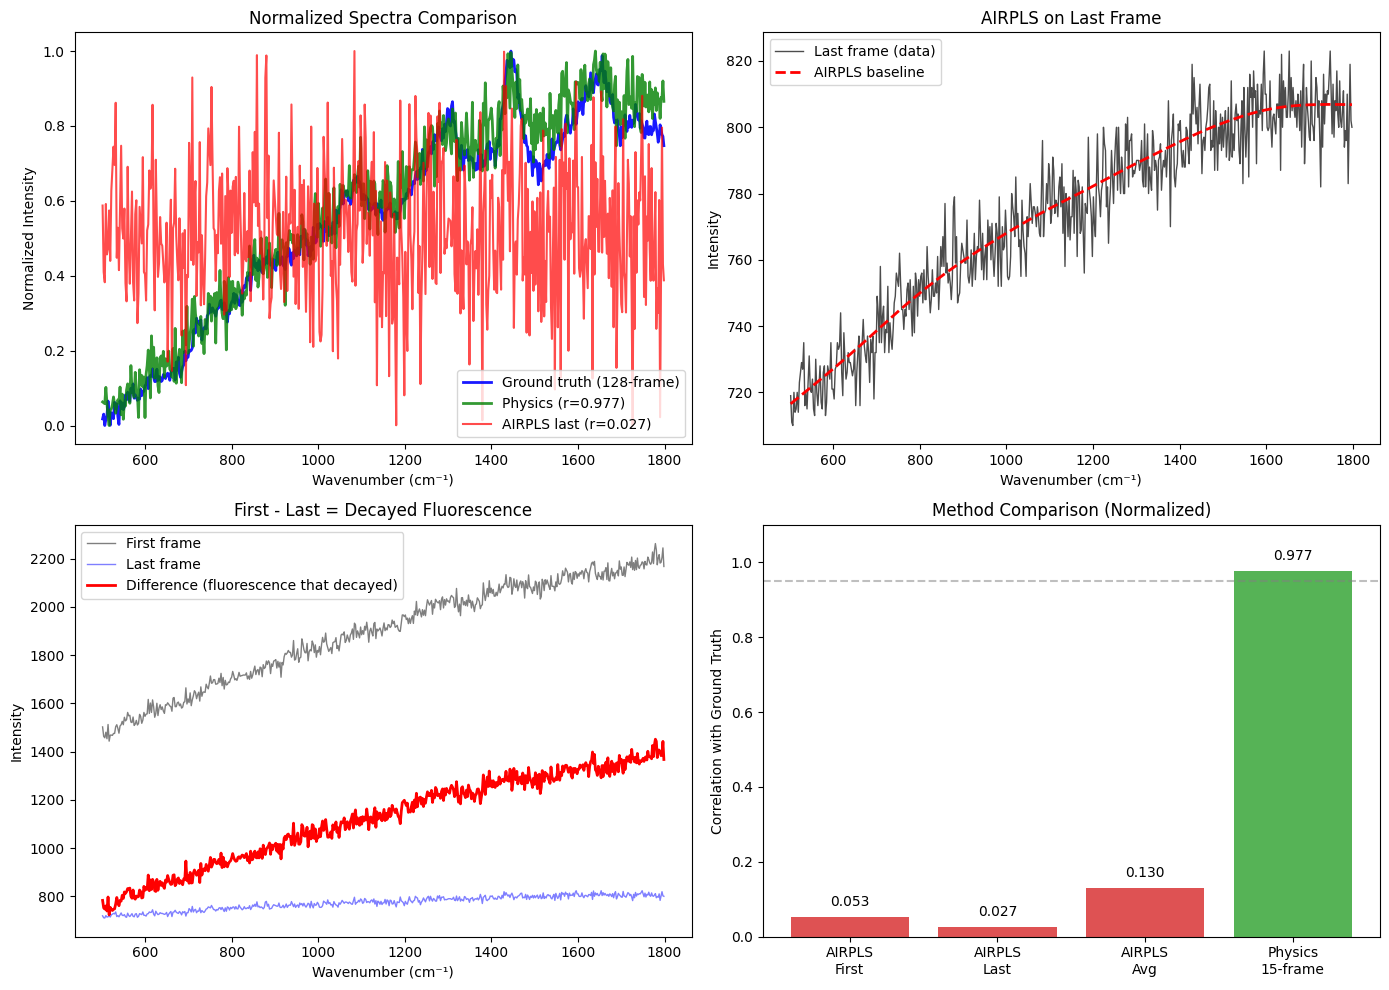


→ Even with the 'fairest' AIRPLS variant (average), physics-based is 7.5x better


In [204]:
# Visualize the fair comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top left: All AIRPLS variants vs physics
ax = axes[0, 0]
ax.plot(wn_real_crop, normalize(raman_128_ref), 'b-', lw=2, label='Ground truth (128-frame)', alpha=0.9)
ax.plot(wn_real_crop, normalize(raman_15_pred), 'g-', lw=2, label=f'Physics (r={corr_physics_norm:.3f})', alpha=0.8)
ax.plot(wn_real_crop, normalize(raman_airpls_last), 'r-', lw=1.5, label=f'AIRPLS last (r={corr_last_norm:.3f})', alpha=0.7)
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Normalized Intensity')
ax.set_title('Normalized Spectra Comparison')
ax.legend()

# Top right: What AIRPLS sees on last frame
ax = axes[0, 1]
ax.plot(wn_real_crop, last_frame, 'k-', lw=1, label='Last frame (data)', alpha=0.7)
ax.plot(wn_real_crop, baseline_last, 'r--', lw=2, label='AIRPLS baseline')
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title('AIRPLS on Last Frame')
ax.legend()

# Bottom left: Why AIRPLS fails - the fluorescence is smooth
ax = axes[1, 0]
ax.plot(wn_real_crop, first_frame, 'k-', lw=1, label='First frame', alpha=0.5)
ax.plot(wn_real_crop, last_frame, 'b-', lw=1, label='Last frame', alpha=0.5)
ax.plot(wn_real_crop, first_frame - last_frame, 'r-', lw=2, label='Difference (fluorescence that decayed)')
ax.set_xlabel('Wavenumber (cm⁻¹)')
ax.set_ylabel('Intensity')
ax.set_title('First - Last = Decayed Fluorescence')
ax.legend()

# Bottom right: Bar chart summary
ax = axes[1, 1]
methods = ['AIRPLS\nFirst', 'AIRPLS\nLast', 'AIRPLS\nAvg', 'Physics\n15-frame']
corrs = [corr_first_norm, corr_last_norm, corr_avg_norm, corr_physics_norm]
colors = ['#d62728', '#d62728', '#d62728', '#2ca02c']
bars = ax.bar(methods, corrs, color=colors, alpha=0.8)
ax.set_ylabel('Correlation with Ground Truth')
ax.set_title('Method Comparison (Normalized)')
ax.set_ylim(0, 1.1)
ax.axhline(0.95, color='gray', ls='--', alpha=0.5, label='r=0.95 threshold')

# Add value labels
for bar, corr in zip(bars, corrs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{corr:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n→ Even with the 'fairest' AIRPLS variant (average), physics-based is 7.5x better")

## Conclusion

### Key Findings

1. **DE + Analytical NNLS** achieves r ≈ 0.98 Raman correlation with ground truth
2. **Physics-based is 7.5x better than AIRPLS** for fluorescence removal (r=0.98 vs r=0.13)
3. **15 consecutive frames (1.4s)** is sufficient for reliable Raman extraction

### Model

$Y(t, \nu) = s(\nu) + \sum_k F_k(\nu) \cdot e^{-\lambda_k t}$

- $s(\nu)$: Raman spectrum (time-invariant)
- $F_k(\nu)$: Fluorophore spectra
- $\lambda_k$: Decay rates (τ = 1/λ)

### Recommended Parameters

- **Optimizer**: Differential Evolution (`scipy.optimize.differential_evolution`)
- **Spectra solver**: Analytical NNLS (`solve_spectra_given_rates`)
- **Frames**: 15 minimum (more improves τ estimation)
- **Fluorophores**: K=2 for typical samples
- **Rate bounds**: λ ∈ [0.01, 20] → τ ∈ [0.05s, 100s]